In [42]:
import project_path

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sqlite3 as sl
from tqdm import tqdm
from typing import List, Any, Tuple, Dict

from lib.utils import iterate_over
from lib.utils import load_config_and_check
from lib.inspector import Inspector

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters

In [2]:
EXP_FOLDER = "qmt_v08" 
SQL_PATH = os.path.join("..", "data", EXP_FOLDER, "qfl.db")
LOG_PATH = os.path.join("..", "data", EXP_FOLDER, "log_fuzzy.txt")
SQL_CONNECTION = sl.connect(SQL_PATH)

In [147]:
OUT_FOLDER = "../data/paper_images"

# Load Data

In [3]:
df_crash = pd.read_sql("""SELECT * from CRASHDATA""", SQL_CONNECTION)
df_data = pd.read_sql("""SELECT * from QFLDATA""", SQL_CONNECTION)
LOG_CONTENT = open(LOG_PATH, 'r').read()
LOG_LINES = LOG_CONTENT.split("\n")

# RQ1: how many syntactically different programs?
can be generated by QMFuzz in a fixed time (2 days, as used by QDiff [31] for the execution)?

In [4]:
# IDEA: we could cluster them in different groups (e.g. single circuit, two circuits, etc...)
# IDEA: we could check which gates were used by each group 
# (i.e. plot the statistic about the use of a certain type of gate)
# plot the stats on the length of the sequence of operations, n.qubits

In [16]:
relevant_columns = [c for c in df_data.columns if c.startswith("source.")]
df_generated_programs = pd.concat(
    [
        df_data[relevant_columns].assign(crash_dataset=False),
        df_crash[relevant_columns].assign(crash_dataset=True)
    ],
    axis=0
)
df_generated_programs.reset_index(drop=True, inplace=True)
df_generated_programs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9535 entries, 0 to 9534
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   source.program_id             9535 non-null   object 
 1   source.selected_gate_set      9535 non-null   object 
 2   source.selected_optimization  9535 non-null   object 
 3   source.shots                  9535 non-null   int64  
 4   source.n_qubits               9535 non-null   int64  
 5   source.n_ops                  9535 non-null   int64  
 6   source.opt_level              9535 non-null   int64  
 7   source.target_gates           0 non-null      object 
 8   source.py_file_path           9535 non-null   object 
 9   source.time_generation        9535 non-null   float64
 10  source.circuit_id             9535 non-null   object 
 11  source.id_quantum_reg         9535 non-null   object 
 12  source.id_classical_reg       9535 non-null   object 
 13  sou

In [143]:
def plot_numeric_attirbute(df, attribute, x_label=None, title=None, **pltargs):
    """Show the distplot of the given attribute."""
    ax = sns.histplot(
        data=df,
        x=attribute,
        bins=np.arange(0.5, df_generated_programs[attribute].max() + 1),
        **pltargs
    )
    if x_label:
        ax.set_xlabel(x_label)
    if title:
        ax.set_title(title)

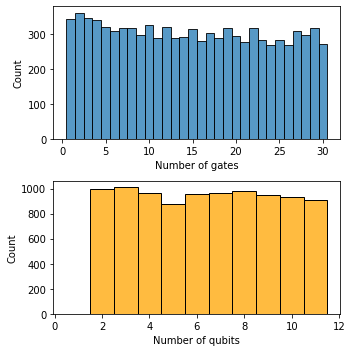

In [148]:
fig, axes = plt.subplots(2, 1, figsize=(5,5))

ax_gates, ax_qubits = axes
plot_numeric_attirbute(
    df=df_generated_programs, 
    attribute='source.n_ops', 
    x_label="Number of gates",
    ax=ax_gates)
plot_numeric_attirbute(
    df=df_generated_programs, 
    attribute='source.n_qubits', 
    x_label="Number of qubits",
    color='orange',
    ax=ax_qubits)
plt.tight_layout()

fig.savefig(os.path.join(OUT_FOLDER, "RQ1_distribution_n_gates_n_qubits.pdf"))

# RQ2: which is the most time expensive step in QMFuzz?

In [38]:
# IDEA: measure the time of each step and create a barchart with percentage and one with absolute values

In [71]:
relevant_time_cols = [
    'program_id',
    'time_exec',
    'source.time_generation',
    #'followup.time_generation', # this attribute is statically copied form source
    'followup.time_metamorph',
    'divergence.ks.time'
]

df_time = pd.concat(
    [
        df_data[relevant_time_cols].assign(crash_dataset=False),
        df_crash[relevant_time_cols].assign(crash_dataset=True)
    ],
    axis=0
)

df_time.head()

,program_id,time_exec,source.time_generation,followup.time_metamorph,divergence.ks.time,crash_dataset
0,bfbab82d5ab141129eee7175026e941d,0.589901,0.011909,0.021907,0.000989,False
1,c5873934b10c49dd8d0405f58ea5f0c8,0.624222,0.010102,0.018670,0.001826,False
2,bc41adcf8fa645ad9062bb917a0fb14d,0.427686,0.013167,0.022862,0.000912,False
3,525327197f884e24a3f94f9f8c05ae58,0.518616,0.009727,0.014531,0.001079,False
4,7f50901fc127422eb6150b59d3ab163f,0.431299,0.006374,0.014831,0.005250,False


In [72]:
df_time_melt = pd.melt(
    df_time, id_vars=['program_id', 'crash_dataset'], 
    value_vars=relevant_time_cols.remove('program_id'))
df_time_melt.head(20)

,program_id,crash_dataset,variable,value
0,bfbab82d5ab141129eee7175026e941d,False,time_exec,0.589901
1,c5873934b10c49dd8d0405f58ea5f0c8,False,time_exec,0.624222
2,bc41adcf8fa645ad9062bb917a0fb14d,False,time_exec,0.427686
3,525327197f884e24a3f94f9f8c05ae58,False,time_exec,0.518616
4,7f50901fc127422eb6150b59d3ab163f,False,time_exec,0.431299
5,8b4791f4f557453e88618e251755f0f0,False,time_exec,0.611226
6,fbf352fc8312487585258d798b02dc4e,False,time_exec,5.667439
7,00786effe2614bcdb6fb0d74c3c0c815,False,time_exec,0.445372
8,e732454b511d4b519bef2a60c0bffc58,False,time_exec,0.514020
9,8c642de04f794471b96ad2619c51bf4a,False,time_exec,0.486126


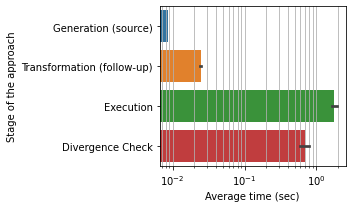

In [156]:
fig, ax = plt.subplots(figsize=(5, 3))

mapping = {
    "source.time_generation": 'Generation (source)',
    "followup.time_metamorph": 'Transformation (follow-up)',
    "time_exec": "Execution",
    "divergence.ks.time": "Divergence Check"
}

sns.barplot(
    data=df_time_melt,
    y='variable',
    x='value',
    order=list(mapping.keys()),
    ax=ax
)

original_labels = ax.get_yticklabels()
ax.set_yticklabels(labels=[
    mapping.get(e._text, e._text)
    for e in original_labels
])
ax.grid(axis='x', which='both')
ax.set_xscale('log')
ax.set_ylabel('Stage of the approach')
ax.set_xlabel('Average time (sec)')

plt.tight_layout()
fig.savefig(os.path.join(OUT_FOLDER, "RQ2_time_analysis.pdf"))

# RQ3: how effective is the varying-threshold approach in reducing the number of false positives?

<AxesSubplot:xlabel='divergence.ks.p-value', ylabel='Count'>

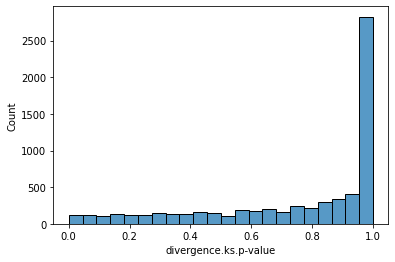

In [98]:
sns.histplot(
    data=df_data,
    x='divergence.ks.p-value'
)

In [106]:
static_treshold = 0.05

threshold_col = "divergence.ks.p-value"
df_programs_w_static_threshold = df_data[
    df_data[threshold_col] <= static_treshold
]
n_alarms_w_static_threshold = len(df_programs_w_static_threshold)
print(f"STATIC THRESHOLD APPROACH produces {n_alarms_w_static_threshold} alarms.")

STATIC THRESHOLD APPROACH produces 121 alarms.


In [111]:
method = 'holm'
pval_col = threshold_col
alpha_level = static_treshold

def count_alarm_with_method(df, pval_col, alpha_level, method):
    df_sorted_pvals = df.sort_values(by=[pval_col])
    k = len(df_sorted_pvals)
    i_star = None
    for i, (idx, row) in enumerate(df_sorted_pvals.iterrows()):
        ordinal_i = i + 1
        P_i = row[pval_col]
        if method == 'holm':
            threshold = alpha_level / (k - ordinal_i + 1)
        elif method == 'bonferroni':
            threshold = alpha_level / (k)
        elif method == 'bh':
            threshold = (alpha_level / (k)) * ordinal_i
        # print(f"(i: {ordinal_i}) current p-value: {P_i} vs threshold: {threshold}")
        if P_i > threshold:
            i_star = i
            print(f"i*: {i_star}")
            break
    return i_star           
#n_alarms_w_varying_threshold = i_star
#print(f"VARYING THRESHOLD APPROACH produces {n_alarms_w_varying_threshold} alarms.")

i*: 23
i*: 23
i*: 24


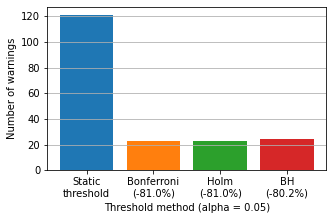

In [154]:
fig, ax = plt.subplots(figsize=(5, 3))

mapping = {
    "bonferroni": 'Bonferroni',
    "holm": 'Holm',
    "bh": "BH"
}

methods_to_try = ['bonferroni', 'holm', 'bh']
n_alarms_w_methods = [
    count_alarm_with_method(
        df=df_data, 
        pval_col=threshold_col,
        alpha_level=static_treshold,
        method=m) for m in methods_to_try]


n_alarms = [n_alarms_w_static_threshold] + n_alarms_w_methods
bars = ['Static\nthreshold'] + list(map(mapping.get, methods_to_try))
y_pos = np.arange(len(bars))

reductions = [
    ((n_alarms_w_static_threshold - abs_val) / n_alarms_w_static_threshold) * 100
    for abs_val in n_alarms
]
bars = [l + f"\n(-{red:.1f}%)" if red > 0 else l
        for l, red in zip(bars, reductions)]

ax.bar(y_pos, n_alarms, color=sns.color_palette()[:len(bars)])
ax.grid(axis='y')
ax.set_ylabel("Number of warnings")
ax.set_xlabel(f"Threshold method (alpha = {static_treshold})")
plt.xticks(y_pos, bars)
plt.show()
fig.savefig(os.path.join(OUT_FOLDER, "RQ3_n_alarms_per_threshold_approach.pdf"))

# RQ4: how many bugs are detected via a divergence as opposed to those detected because of a crash?

In [43]:
from copy import deepcopy

def normalize_names(df: pd.DataFrame, col: str, mapping:List[Tuple[str, str]]):
    """Replace the value of the given column according to the mapping.
    
    Each cell that contains the first string, will be replaced completely 
    with the second string of the tuple."""
    df = deepcopy(df)
    for hook, replacement in mapping:
        df.loc[df[col].str.contains(hook), col] = replacement
    return df

In [44]:
from collections import Counter

K = 10
print(f"TOP {K} CRASH MESSAGES (without normalization)")
c = Counter(df_crash["exceptions.followup"])
c.most_common(10)

TOP 10 CRASH MESSAGES (without normalization)


[("'qargs not in this circuit'", 2519),
 ('"Cannot unroll the circuit to the given basis, [\'rx\', \'ry\', \'rz\', \'p\', \'cx\']. Instruction id not found in equivalence library and no rule found to expand."',
  31),
 ('too many subscripts in einsum', 22),
 ('"Cannot unroll the circuit to the given basis, [\'ccx\', \'h\']. Instruction id not found in equivalence library and no rule found to expand."',
  15),
 ('"Cannot unroll the circuit to the given basis, [\'cx\', \'h\', \'s\', \'t\']. Instruction id not found in equivalence library and no rule found to expand."',
  12),
 ('"Unable to map source basis {(\'cu1\', 2), (\'cu3\', 2), (\'u3\', 1), (\'sxdg\', 1), (\'rxx\', 2), (\'swap\', 2), (\'cz\', 2), (\'ecr\', 2), (\'sx\', 1)} to target basis {\'reset\', \'t\', \'h\', \'s\', \'measure\', \'delay\', \'snapshot\', \'cx\', \'barrier\'} over library <qiskit.circuit.equivalence.EquivalenceLibrary object at 0x7f6256a20eb0>."',
  4),
 ('"Unable to map source basis {(\'swap\', 2), (\'rxx\', 2

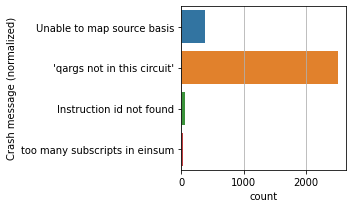

In [157]:
exception_mapping = [
    ["Unable to map source basis", "Unable to map source basis"],
    ["Instruction id not found", "Instruction id not found"],
]

df_crash_norm = normalize_names(
    df=df_crash, 
    col="exceptions.followup",
    mapping=exception_mapping
)

fig, ax = plt.subplots(figsize=(5, 3))

sns.countplot(
    data=df_crash_norm,
    y="exceptions.followup",
    ax=ax
)
ax.set_ylabel("Crash message (normalized)")
ax.grid(axis='x')
#ax.set_title("Crash Messages (Normalized)")
plt.tight_layout()
fig.savefig(os.path.join(OUT_FOLDER, "RQ4_count_plot_crash_messages.pdf"))

# RQ5: which real bugs have been found in Qiskit via metamorphic testing?
See interesting cases folders + discussion section + qiskit issues (Notebook number 37)